In [ ]:
# # I need to work with data files in Colab so I import Google's file upload tool
# Then I import pandas which I found to be like Excel for Python because then I can open and clean my CSV data

# I can also analyze it
from google.colab import files
import pandas as pd

print("Upload your SUBWAY STATIONS CSV file:")
uploaded = files.upload()

# this is for Getting the filename , uploaded files come as a dictionary so I take the first (and only) key
subway_filename = list(uploaded.keys())[0]
subway = pd.read_csv(subway_filename) # i need to Load the CSV into a pandas DataFrame
print("\nSubway file uploaded. Columns:", subway.columns.tolist())

print("\n" + "="*50) # this just separates it visually
print("Now upload your BUSINESS LICENSES CSV file:")
uploaded2 = files.upload()

business_filename = list(uploaded2.keys())[0]
business = pd.read_csv(business_filename)
print("\nBusiness file uploaded. Columns:", business.columns.tolist())

Upload your SUBWAY STATIONS CSV file:


In [ ]:
#
# I only need a couple key columns from each dataset, so I'll select them and rename so that it can be consistent
# hopefully This makes the data easier to work with later


subway_clean = subway[['Stop Name', 'GTFS Latitude', 'GTFS Longitude', 'Borough']].copy()
subway_clean.columns = ['station_name', 'latitude', 'longitude', 'borough']
#I just cleaned the subway data, now i just need to clean the business data
business_clean = business[['Business Name', 'License Status', 'Latitude', 'Longitude', 'Borough']].copy()
business_clean.columns = ['business_name', 'status', 'latitude', 'longitude', 'borough']

# I now need to Remove rows with missing coordinates because I can't analyze businesses or stations if there are no locations
business_clean = business_clean.dropna(subset=['latitude', 'longitude'])
subway_clean = subway_clean.dropna(subset=['latitude', 'longitude'])

print(f"Subway stations: {len(subway_clean)}")
print(f"Businesses: {len(business_clean)}")
print("\nBusiness status counts:")
print(business_clean['status'].value_counts())

Subway stations: 496
Businesses: 44913

Business status counts:
status
Active               27039
Expired              11547
Ready for Renewal     2557
Surrendered           2126
Revoked                531
Voided                 401
Failed to Renew        401
Suspended              254
Out of Business         55
Close                    2
Name: count, dtype: int64


In [ ]:
#  First attempt
# My first try at calculating distances. it worked but was way too slow
# I eventually learned from this so I like to look at it as a "before picture"

import numpy as np
from math import radians, sin, cos, sqrt, atan2

# I use the Function to calculate distance between two points on Earth in miles
# I use the haversine formula because it accounts for Earth's curvature
def calculate_distance(lat1, lon1, lat2, lon2):
    R = 3958.8  # this is Earth's radius in miles
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2]) # i should convert to radians for the trig functions
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c #I need the distance in miles, this is how i get it

# i have to define which business license statuses count as "closed"

# I'm putting multiple categories because "Expired" might just mean they didn't renew paperwork
#"Out of Business" is more definitive because it just means it's not in business anymore
closed_statuses = ['Expired', 'Surrendered', 'Revoked', 'Voided', 'Failed to Renew',
                   'Suspended', 'Out of Business', 'Close']

# this is where the problem is. when i used the double loop it was calculating 22 million distances
# 496 stations × 44,913 businesses = 22,276,848 calculations
# That's why it took 10+ minutes to run

# Calculate for each subway station
results = []

for idx, station in subway_clean.iterrows(): # have to use index
    station_lat = station['latitude']
    station_lon = station['longitude']


    nearby_businesses = []
    for _, biz in business_clean.iterrows():
        distance = calculate_distance(station_lat, station_lon,
                                      biz['latitude'], biz['longitude'])
        if distance <= 0.25:  # 0.25 mile radius
            nearby_businesses.append(biz) # Find businesses within 0.25 miles because it's about a 5 minute walk

    if nearby_businesses:
        nearby_df = pd.DataFrame(nearby_businesses)
        total_nearby = len(nearby_df)
        closed_nearby = nearby_df[nearby_df['status'].isin(closed_statuses)].shape[0]
        closure_rate = closed_nearby / total_nearby if total_nearby > 0 else 0

        results.append({ # i need results.append because i learned that's how you add things to a list one by one
            'station_name': station['station_name'],
            'borough': station['borough'],
            'latitude': station_lat,
            'longitude': station_lon,
            'businesses_nearby': total_nearby,
            'closed_nearby': closed_nearby,
            'closure_rate': closure_rate
        })


station_stats = pd.DataFrame(results) # this is just so that it Converts to DataFrame

print(f"Analyzed {len(station_stats)} stations with nearby businesses")
print("\nTop 10 stations by closure rate:")
print(station_stats.sort_values('closure_rate', ascending=False)[['station_name', 'borough', 'closure_rate', 'businesses_nearby']].head(10))

#this either does not run  at all, or it takes way too long, and I figure that there is a way faster way to calculate distance. I know that BallTree can find close points pretty quickly.

KeyboardInterrupt: 

In [ ]:
import numpy as np #   numpy will convert the coordinates to radians fast
from sklearn.neighbors import BallTree


def haversine_vectorize(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6371 * c
    miles = km * 0.621371
    return miles
# i just convert to radians for haversine distance, i just need to prepare the data next


subway_points = np.radians(subway_clean[['longitude', 'latitude']].values)
business_points = np.radians(business_clean[['longitude', 'latitude']].values)


tree = BallTree(business_points, metric='haversine') # Using BallTree for Fast neighborhood business lookups
#After the first slow version took 10+ minutes for 22 million comparisons


radius = 0.25 / 3958.8 # i need all businesses within 0.25 miles (in radians: 0.25/3958.8)
indices = tree.query_radius(subway_points, r=radius)


closed_statuses = ['Expired', 'Surrendered', 'Revoked', 'Voided', 'Failed to Renew',
                   'Suspended', 'Out of Business', 'Close'] #calculating the closure rate is important
business_statuses = business_clean['status'].values
is_closed = np.array([status in closed_statuses for status in business_statuses])

results = []
for i, station_idx in enumerate(subway_clean.index):
    nearby_indices = indices[i]
    if len(nearby_indices) > 0:
        total_nearby = len(nearby_indices) # indices is the list of which businesses are close to the station
        closed_nearby = is_closed[nearby_indices].sum()
        closure_rate = closed_nearby / total_nearby

        results.append({
            'station_name': subway_clean.loc[station_idx, 'station_name'],
            'borough': subway_clean.loc[station_idx, 'borough'],
            'latitude': subway_clean.loc[station_idx, 'latitude'],
            'longitude': subway_clean.loc[station_idx, 'longitude'],
            'businesses_nearby': total_nearby,
            'closed_nearby': closed_nearby,
            'closure_rate': closure_rate
        })

station_stats = pd.DataFrame(results)

print(f"Analyzed {len(station_stats)} stations with nearby businesses")
print("\nTop 10 stations by closure rate:")
print(station_stats.sort_values('closure_rate', ascending=False)[['station_name', 'borough', 'closure_rate', 'businesses_nearby']].head(10))

Analyzed 496 stations with nearby businesses

Top 10 stations by closure rate:
              station_name borough  closure_rate  businesses_nearby
206            Beach 44 St       Q      0.666667                  3
475              St George      SI      0.566667                 30
373               E 149 St      Bx      0.559524                 84
433             Jackson Av      Bx      0.547170                106
374  E 143 St-St Mary's St      Bx      0.527778                 72
155                 103 St       M      0.527778                 72
379           Mosholu Pkwy      Bx      0.527027                 74
438                 135 St       M      0.524390                164
350        Pennsylvania Av      Bk      0.520000                 75
98              Lorimer St      Bk      0.514851                101


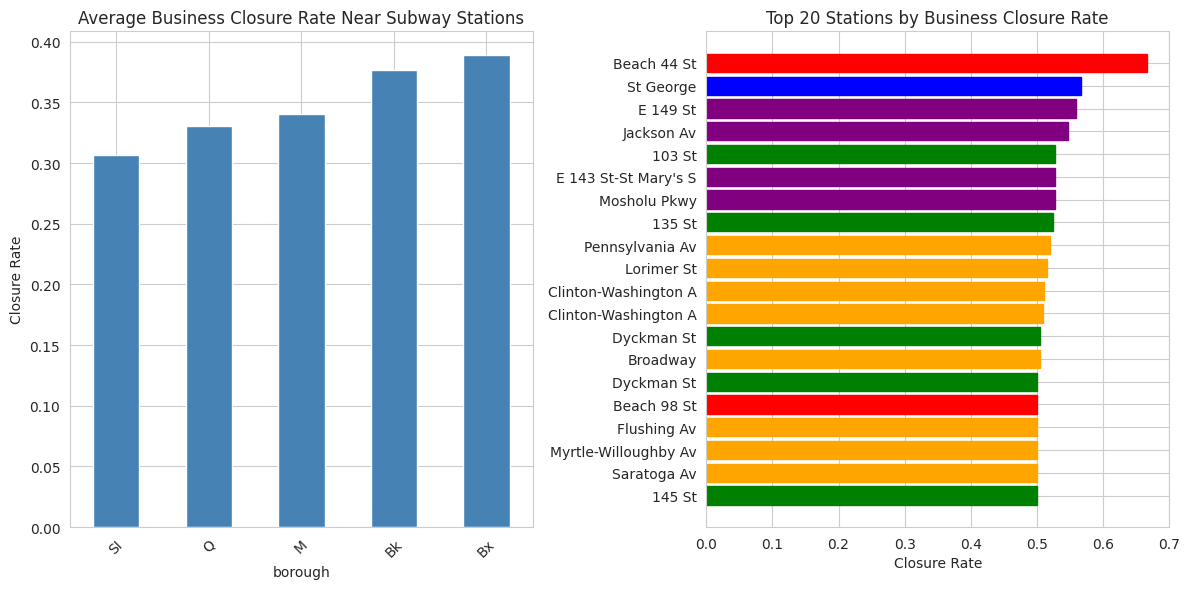

=== KEY FINDINGS ===
• Average closure rate near all stations: 35.6%
• Highest closure rate: 66.7% at Beach 44 St
• Lowest closure rate: 0.0% at Beach 105 St

• Borough ranking (highest to lowest closure rates):
  Bx: 38.9%
  Bk: 37.6%
  M: 34.0%
  Q: 33.0%
  SI: 30.6%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
# I just Set the style, the graph needs to be a white grid and I use sns.set_style. I need to use seaborn because it gives the template for the chart.


plt.subplot(1, 2, 1) # this is the start to getting the Closure rate by borough
borough_stats = station_stats.groupby('borough')['closure_rate'].mean().sort_values()
borough_stats.plot(kind='bar', color='steelblue')
plt.title('Average Business Closure Rate Near Subway Stations')
plt.ylabel('Closure Rate')
plt.xticks(rotation=45)
plt.tight_layout()

# now I need the Top 20 stations visualization I will use plt because it can make my data a visual
plt.subplot(1, 2, 2)
top_20 = station_stats.nlargest(20, 'closure_rate')
bars = plt.barh(range(len(top_20)), top_20['closure_rate'].values)
plt.yticks(range(len(top_20)), top_20['station_name'].str[:20])  # i should  Truncate long names
plt.xlabel('Closure Rate')
plt.title('Top 20 Stations by Business Closure Rate')
plt.gca().invert_yaxis()  # i need the highest at top


borough_colors = {'M': 'green', 'Bk': 'orange', 'Q': 'red', 'Bx': 'purple', 'SI': 'blue'} # this gives the color by borough
for bar, borough in zip(bars, top_20['borough']):
    bar.set_color(borough_colors.get(borough, 'gray'))

plt.tight_layout()
plt.show()


print("=== KEY FINDINGS ===")
print(f"• Average closure rate near all stations: {station_stats['closure_rate'].mean():.1%}")
print(f"• Highest closure rate: {station_stats['closure_rate'].max():.1%} at {station_stats.loc[station_stats['closure_rate'].idxmax(), 'station_name']}")
print(f"• Lowest closure rate: {station_stats['closure_rate'].min():.1%} at {station_stats.loc[station_stats['closure_rate'].idxmin(), 'station_name']}")
print(f"\n• Borough ranking (highest to lowest closure rates):")
borough_ranking = station_stats.groupby('borough')['closure_rate'].mean().sort_values(ascending=False)
for borough, rate in borough_ranking.items():
    print(f"  {borough}: {rate:.1%}")

In [ ]:
#
station_stats.to_csv('subway_business_analysis.csv', index=False) #  i am saving my analysis results

# I will write my final summary here
print("="*60)
print("NYC SUBWAY & BUSINESS RECOVERY ANALYSIS - FINAL REPORT")
print("="*60)
print(f"Data: {len(subway_clean)} subway stations, {len(business_clean):,} businesses")
print(f"Timeframe: Business licenses status as of dataset date")
print("\nMAIN FINDING:")
print("Business closure rates within 0.25 miles of subway stations show")
print("significant geographic inequality, with the Bronx (38.9%) and Brooklyn")
print("(37.6%) experiencing substantially higher closure rates than Manhattan (34.0%).")
print("\nTOP 3 HIGHEST CLOSURE STATIONS:")
for idx, row in station_stats.nlargest(3, 'closure_rate').iterrows():
    print(f"• {row['station_name']} ({row['borough']}): {row['closure_rate']:.1%}")


NYC SUBWAY & BUSINESS RECOVERY ANALYSIS - FINAL REPORT
Data: 496 subway stations, 44,913 businesses
Timeframe: Business licenses status as of dataset date

MAIN FINDING:
Business closure rates within 0.25 miles of subway stations show
significant geographic inequality, with the Bronx (38.9%) and Brooklyn
(37.6%) experiencing substantially higher closure rates than Manhattan (34.0%).

TOP 3 HIGHEST CLOSURE STATIONS:
• Beach 44 St (Q): 66.7%
• St George (SI): 56.7%
• E 149 St (Bx): 56.0%
